In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm


from networks import DeepSurv, NegativeLogLikelihood
from utils import c_index
import torch

In [2]:
device = 'cuda:0'

In [11]:
config = {'train': {
  'learning_rate': 0.0001,
  'lr_decay_rate': 0.2,
  'optimizer': 'Adam'},
 'network': {'drop': 0.5,
  'norm': True,
  'dims': [14,100, 1],
  'activation': 'ReLU',
  'l2_reg': 0.1}}

model = DeepSurv(config['network'], device)
#print(model)

loss_function = NegativeLogLikelihood(config['network']).to(device)
#print(loss_function)


In [12]:
optimizer = eval('torch.optim.{}'.format(config['train']['optimizer']))(
        model.parameters(), lr=config['train']['learning_rate'])

In [13]:
from sksurv.datasets import load_whas500
data_x, data_y = load_whas500()
life = pd.concat([data_x, pd.DataFrame(data_y)], axis = 1)
#from sksurv.preprocessing import OneHotEncoder

#life = OneHotEncoder().fit_transform(life)

life

afb   age av3       bmi chf cvd  diasbp gender     hr   los miord mitype  \
0     1  83.0   0  25.54051   0   1    78.0      0   89.0   5.0     1      0   
1     0  49.0   0  24.02398   0   1    60.0      0   84.0   5.0     0      1   
2     0  70.0   0  22.14290   0   0    88.0      1   83.0   5.0     0      1   
3     0  70.0   0  26.63187   1   1    76.0      0   65.0  10.0     0      1   
4     0  70.0   0  24.41255   0   1    85.0      0   63.0   6.0     0      1   
..   ..   ...  ..       ...  ..  ..     ...    ...    ...   ...   ...    ...   
495   1  76.0   0  27.96454   0   1    88.0      1   68.0   1.0     0      1   
496   0  76.0   0  24.26862   0   1    96.0      1   88.0   3.0     0      0   
497   1  57.0   0  42.13576   0   1    74.0      1  123.0   3.0     0      0   
498   0  67.0   0  27.40905   0   1    62.0      0   59.0   1.0     0      1   
499   0  98.0   0  19.48575   0   1   100.0      0   99.0   3.0     0      1   

    sho  sysbp  fstat  lenfol  
0     0  152.0  False  2178.0  
1     0  120.0  False  2172.0  
2     0  147.0  False  2190.0  
3     0  123.0   True   297.0  
4     0  135.0  False  2131.0  
..   ..    ...    ...     ...  
495   0  112.0   True    10.0  
496   0  208.0  False   662.0  
497   0  120.0  False   725.0  
498   0  112.0  False   532.0  
499   0  160.0   True   259.0  

[500 rows x 16 columns]

In [14]:
class SurvivalDataset(torch.utils.data.Dataset):
    
    def __init__(self, covx, event, time):
        '''
        note that inputs are normalized numpy
        '''
        self.covx = covx
        self.event = event
        self.time = time
        print(covx.shape, event.shape, time.shape)
    
    def __getitem__(self, index):
        # gets data with index of item
        X_item = self.covx[index] # (m)
        e_item = self.event[index] # (1)
        y_item = self.time[index] # (1)

        # constructs torch.Tensor object
        X_tensor = torch.from_numpy(X_item).to(torch.float32)
        e_tensor = torch.from_numpy(e_item).to(torch.float32)
        y_tensor = torch.from_numpy(y_item).to(torch.float32)
        return X_tensor, y_tensor, e_tensor

    def __len__(self):
        return self.covx.shape[0]

In [22]:
cols = list(life.columns)

cols.remove('fstat')
cols.remove('lenfol')
covx = life

import pandas as pd
from sklearn import preprocessing

x = covx.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
covx, event, time = df[list(range(14))].to_numpy(), df[[14]].to_numpy(), df[[15]].to_numpy()

In [23]:
ratio = 0.9
train_valid_dataset = SurvivalDataset(covx[:400, :], event[:400], time[:400])

train_len = int(len(train_valid_dataset)*ratio)
valid_len = len(train_valid_dataset) - train_len

train_dataset, valid_dataset = torch.utils.data.random_split(train_valid_dataset, [train_len, valid_len])

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_dataset.__len__())
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=valid_dataset.__len__())



test_dataset = SurvivalDataset(covx[400:, :], event[400:], time[400:])
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=test_dataset.__len__())

print(train_dataset.__len__(), valid_dataset.__len__(), test_dataset.__len__())

(400, 14) (400, 1) (400, 1)
(100, 14) (100, 1) (100, 1)
360 40 100


In [24]:
class Trainer():
    def initialize(self, train_loader, valid_loader, test_loader, optimizer, model, loss_function, c_index_function, device, freq = 100):
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.model = model.to(device)
        self.loss_function = loss_function.to(device)
        self.c_index_function = c_index_function
        self.device = device
        self.freq = freq
    
    def one_epoch_train(self, epoch):
        self.model.train()
        loss_total = list()
        c_index_total = list()
        for x, y, e in self.train_loader:
            x = x.to(self.device)
            y = y.to(self.device)
            e = e.to(self.device)
            risk_pred = self.model(x)
            train_loss = self.loss_function(risk_pred, y, e, self.model, self.device)
            train_c = self.c_index_function(-risk_pred, y, e)

            self.optimizer.zero_grad()
            train_loss.backward()
            self.optimizer.step()

            loss_total.append(train_loss.cpu().detach().item())
            c_index_total.append(train_c)

        return np.array(loss_total).mean(), np.array(c_index_total).mean()
    
    def one_epoch_valid(self, epoch):
        self.model.eval()
        loss_total = list()
        c_index_total = list()
        with torch.no_grad():
            for x, y, e in self.valid_loader:
                x = x.to(self.device)
                y = y.to(self.device)
                e = e.to(self.device)

                risk_pred = self.model(x).to(self.device)
                valid_loss = self.loss_function(risk_pred, y, e, self.model, self.device)
                valid_c = self.c_index_function(-risk_pred, y, e)

                loss_total.append(valid_loss.cpu().detach().item())
                c_index_total.append(valid_c)


            return np.array(loss_total).mean(), np.array(c_index_total).mean()

    def test(self):
        self.model.eval()
        with torch.no_grad():
            for x, y, e in self.test_loader:
                x = x.to(self.device)
                y = y.to(self.device)
                e = e.to(self.device)

                risk_pred = self.model(x).to(self.device)
                test_loss = self.loss_function(risk_pred, y, e, self.model, self.device)
                test_c = self.c_index_function(-risk_pred, y, e)


                print(f'Test || loss : {round(test_loss.cpu().detach().item(), 3)} / c-index : {round(test_c, 3)}')

In [25]:
trainer = Trainer()
trainer.initialize(
    train_loader,
    valid_loader, 
    test_loader,
    optimizer,
    model,
    loss_function,
    c_index_function = c_index,
    device = 'cuda:0'
)

In [26]:
epochs = 3000
train_result = list()
valid_result = list()
for epoch in tqdm(range(epochs)):
    train_result.append(trainer.one_epoch_train(epoch))
    valid_result.append(trainer.one_epoch_valid(epoch))
trainer.test()

train_result = np.stack(train_result)
valid_result = np.stack(valid_result)

  0%|          | 0/3000 [00:00<?, ?it/s]

Test || loss : 0.878 / c-index : 0.705


In [27]:
train_result.shape

(3000, 2)

Test || loss : 0.878 / c-index : 0.705


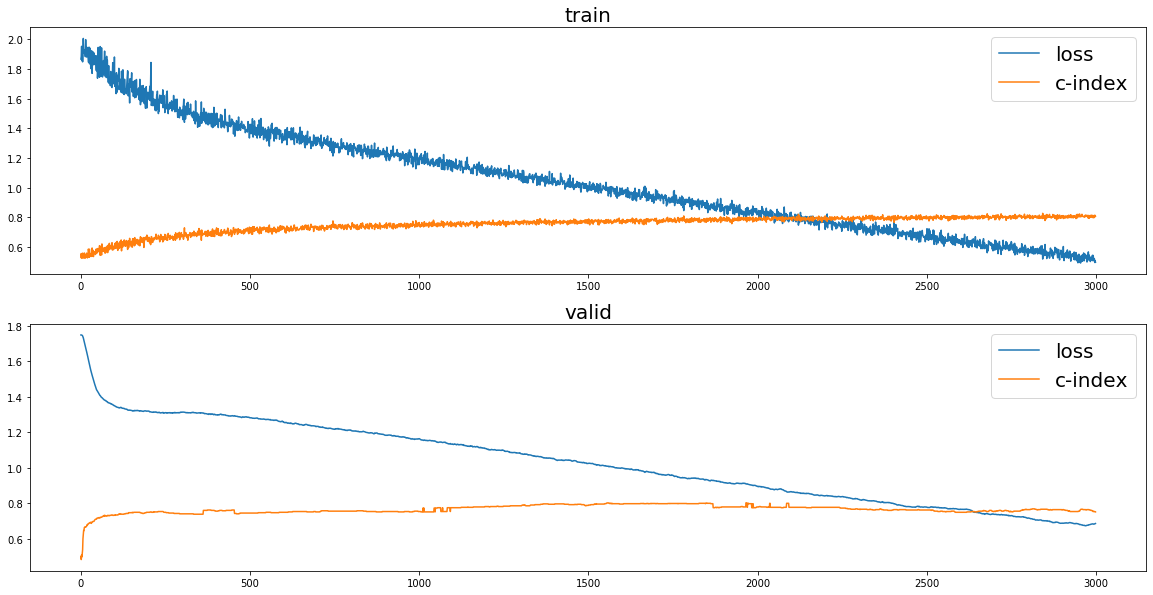

In [28]:
plt.figure(figsize = (20, 10))
plt.subplot(2, 1, 1)
plt.plot(train_result[:, 0], label = 'loss')
plt.plot(train_result[:, 1], label = 'c-index')
plt.title('train', fontsize = 20)
plt.legend(fontsize = 20)

plt.subplot(2, 1, 2)
plt.plot(valid_result[:, 0], label = 'loss')
plt.plot(valid_result[:, 1], label = 'c-index')
plt.title('valid', fontsize = 20)
plt.legend(fontsize = 20)


trainer.test()

In [29]:
import torch.nn as nn
class WrappedModel(nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, x):
        x = torch.tensor(x.to_numpy(), dtype=torch.float32).to(device)
        x = self.model(x)
        return x.detach().cpu().numpy()

    # Add the predict method
    def predict(self, x):
        return self.forward(x)

wrapped_model = WrappedModel(model)

In [37]:
feature_names = [f'feature_{i}' for i in range(1, 15)]
surv_XDF = pd.DataFrame(df[list(range(14))].to_numpy(), columns=feature_names)

In [38]:
surv_XDF

feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0          1.0   0.716216        0.0   0.393008        0.0        1.0   
1          0.0   0.256757        0.0   0.345308        0.0        1.0   
2          0.0   0.540541        0.0   0.286142        0.0        0.0   
3          0.0   0.540541        0.0   0.427334        1.0        1.0   
4          0.0   0.540541        0.0   0.357530        0.0        1.0   
..         ...        ...        ...        ...        ...        ...   
495        1.0   0.621622        0.0   0.469251        0.0        1.0   
496        0.0   0.621622        0.0   0.353003        0.0        1.0   
497        1.0   0.364865        0.0   0.914979        0.0        1.0   
498        0.0   0.500000        0.0   0.451779        0.0        1.0   
499        0.0   0.918919        0.0   0.202567        0.0        1.0   

     feature_7  feature_8  feature_9  feature_10  feature_11  feature_12  \
0     0.375000        0.0   0.357616    0.106383         1.0         0.0   
1     0.281250        0.0   0.324503    0.106383         0.0         1.0   
2     0.427083        1.0   0.317881    0.106383         0.0         1.0   
3     0.364583        0.0   0.198675    0.212766         0.0         1.0   
4     0.411458        0.0   0.185430    0.127660         0.0         1.0   
..         ...        ...        ...         ...         ...         ...   
495   0.427083        1.0   0.218543    0.021277         0.0         1.0   
496   0.468750        1.0   0.350993    0.063830         0.0         0.0   
497   0.354167        1.0   0.582781    0.063830         0.0         0.0   
498   0.291667        0.0   0.158940    0.021277         0.0         1.0   
499   0.489583        0.0   0.423841    0.063830         0.0         1.0   

     feature_13  feature_14  
0           0.0    0.508021  
1           0.0    0.336898  
2           0.0    0.481283  
3           0.0    0.352941  
4           0.0    0.417112  
..          ...         ...  
495         0.0    0.294118  
496         0.0    0.807487  
497         0.0    0.336898  
498         0.0    0.294118  
499         0.0    0.550802  

[500 rows x 14 columns]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


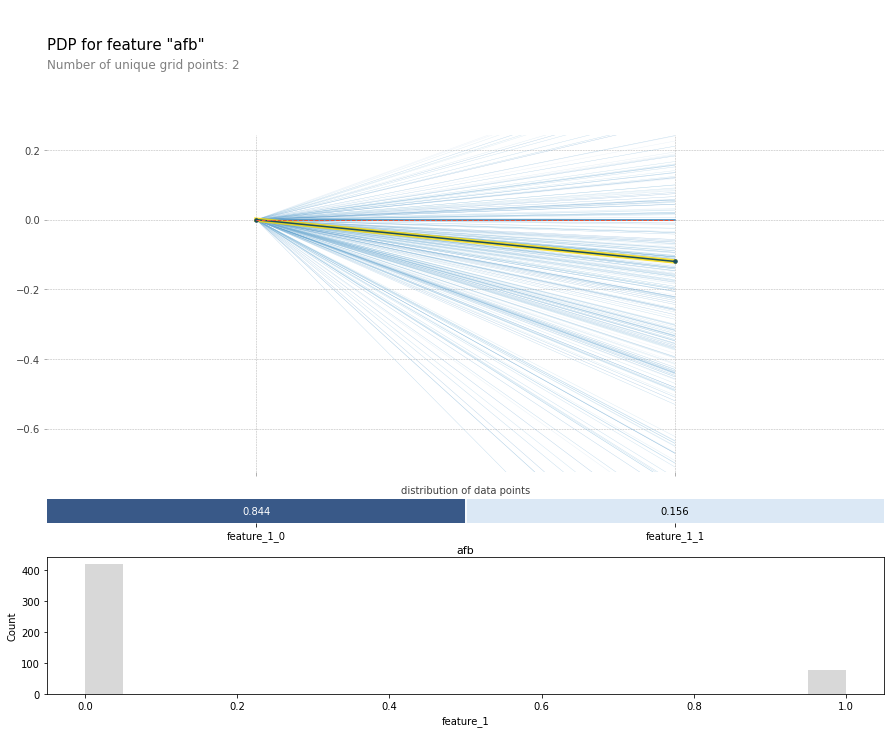

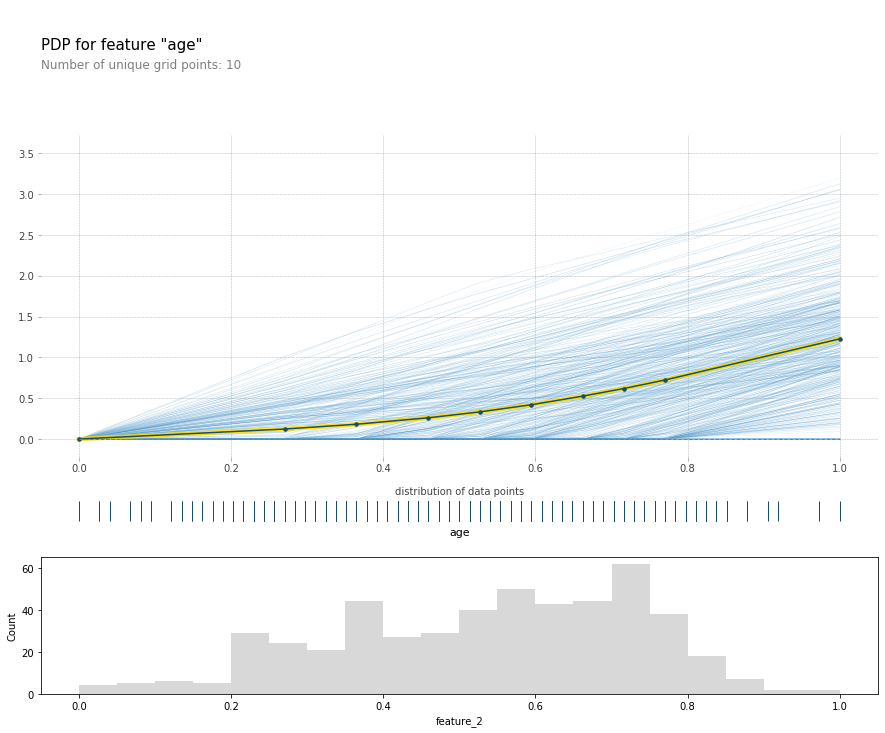

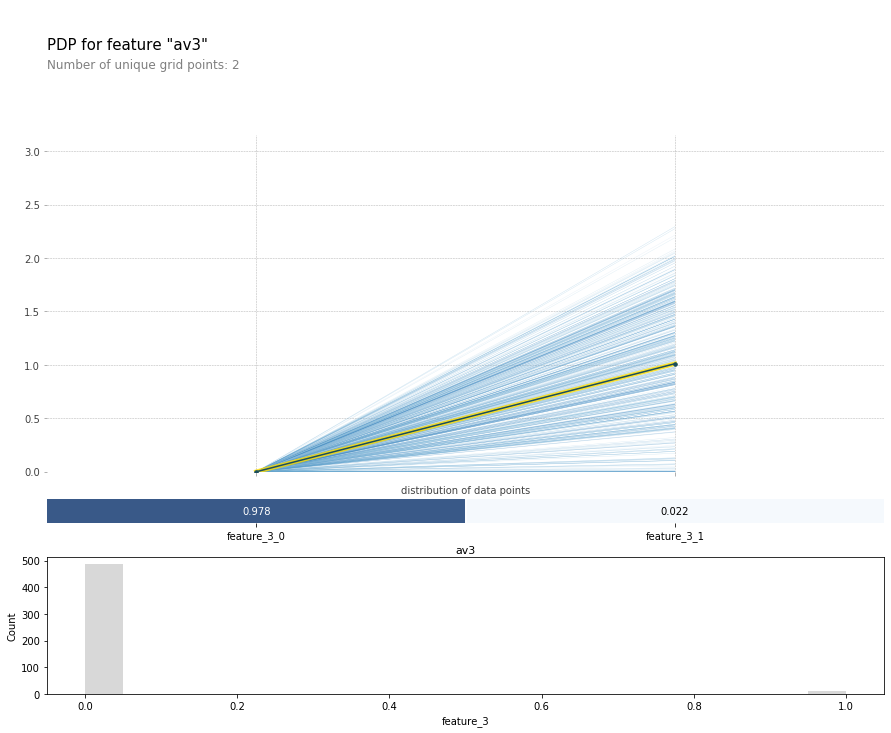

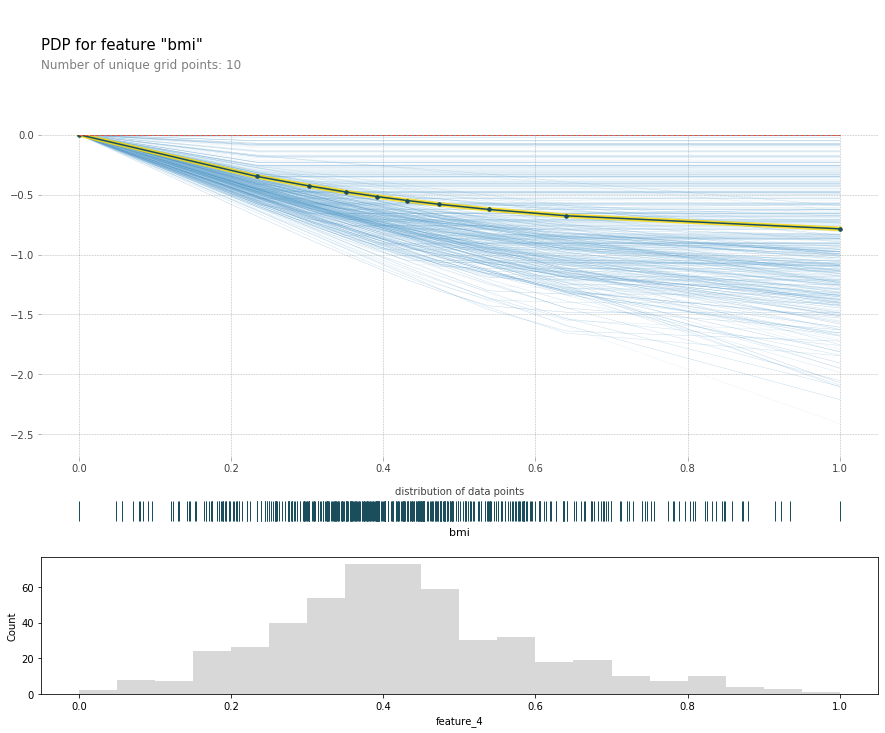

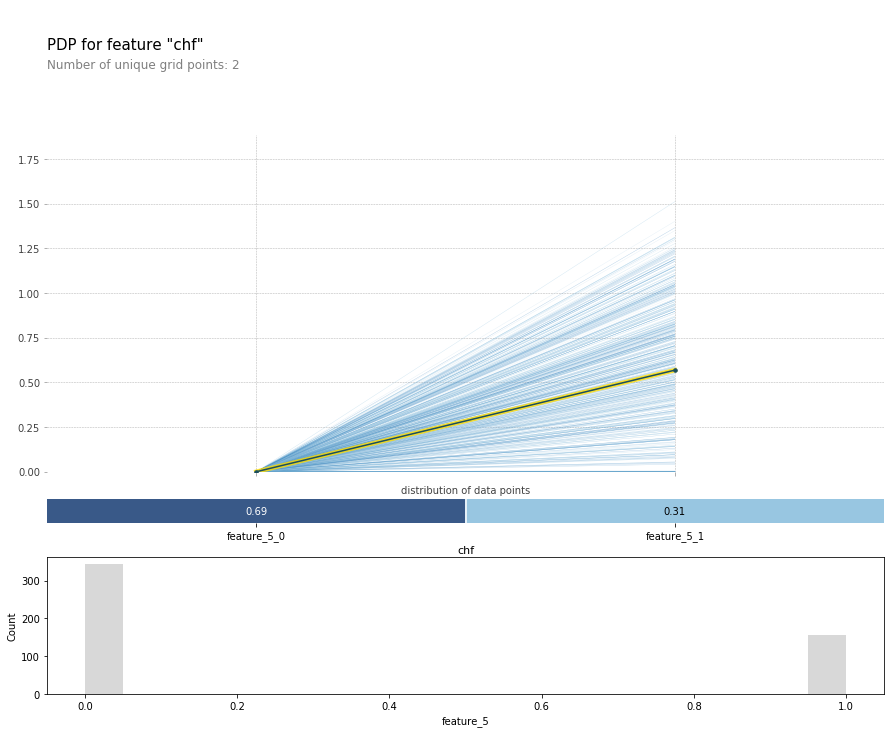

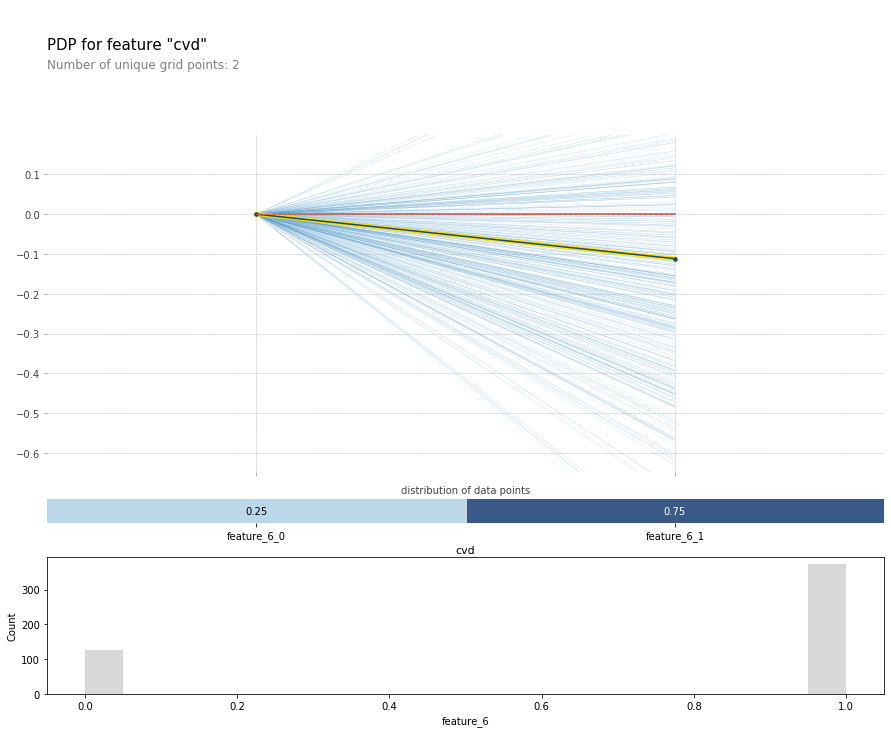

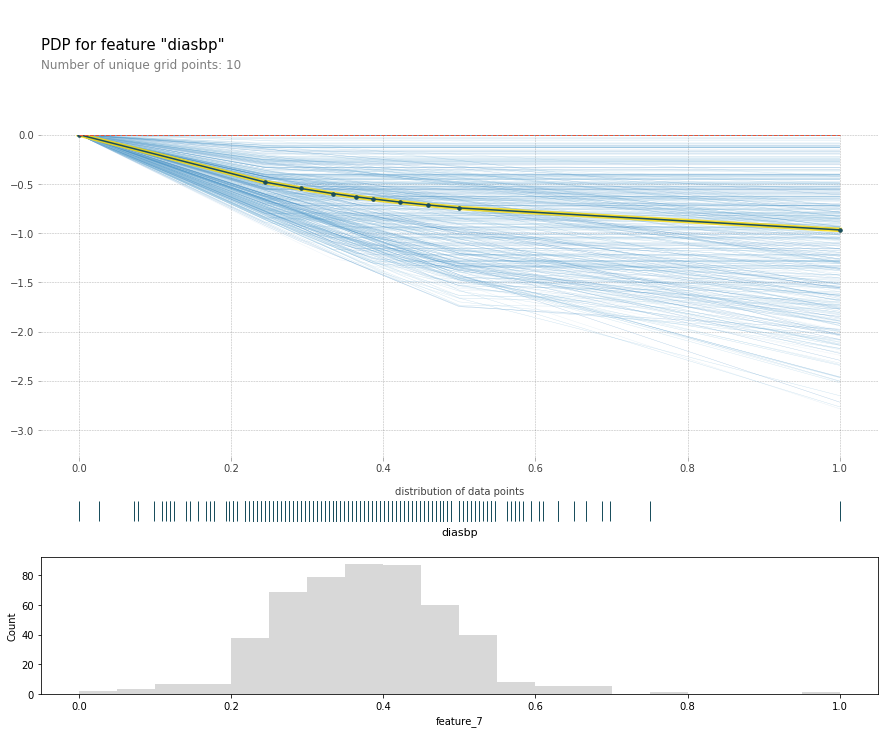

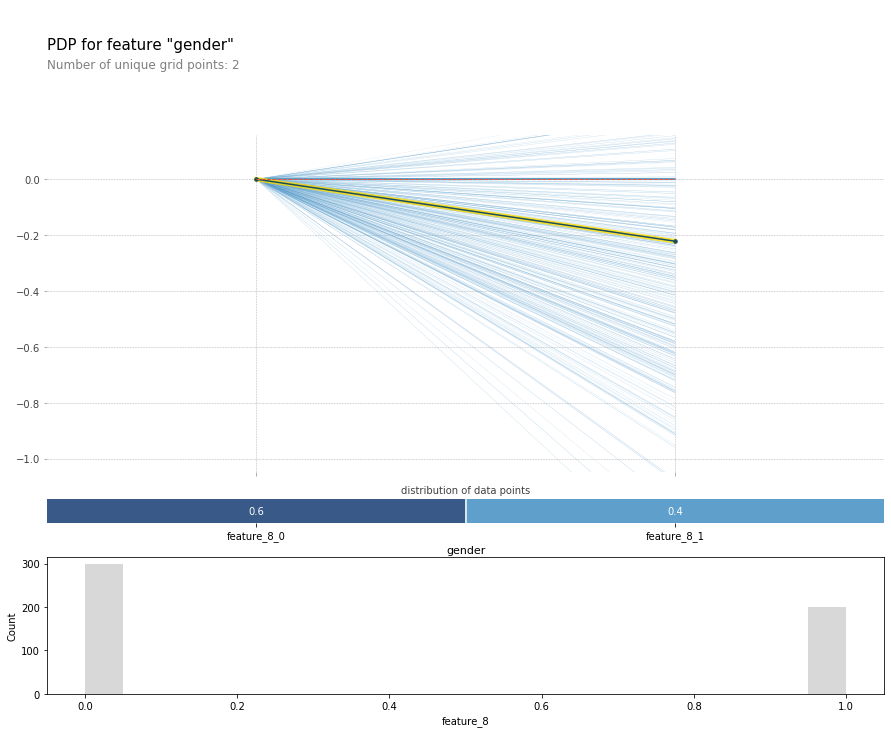

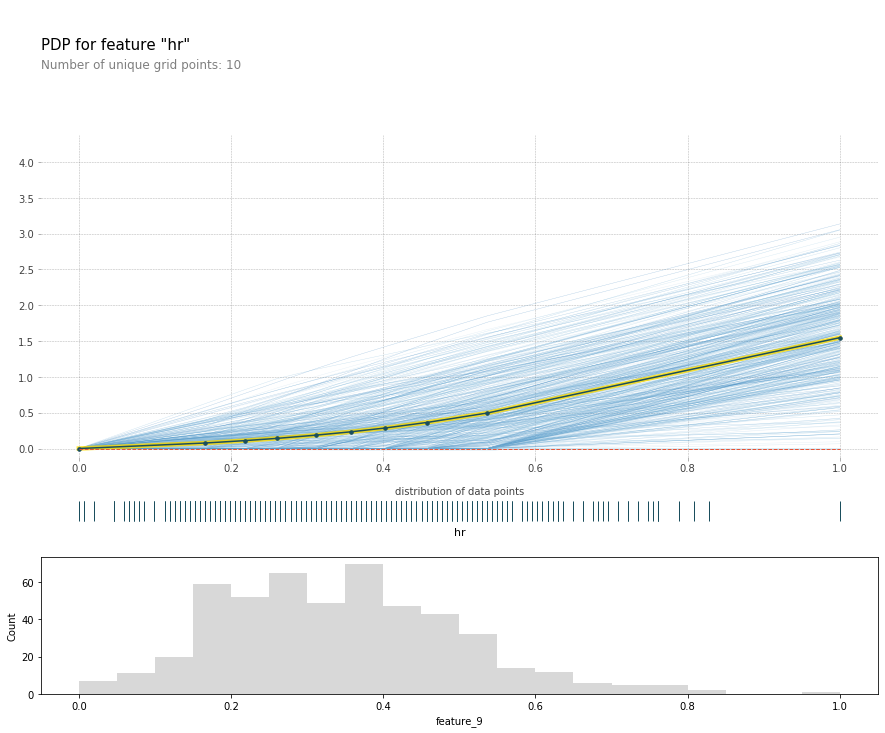

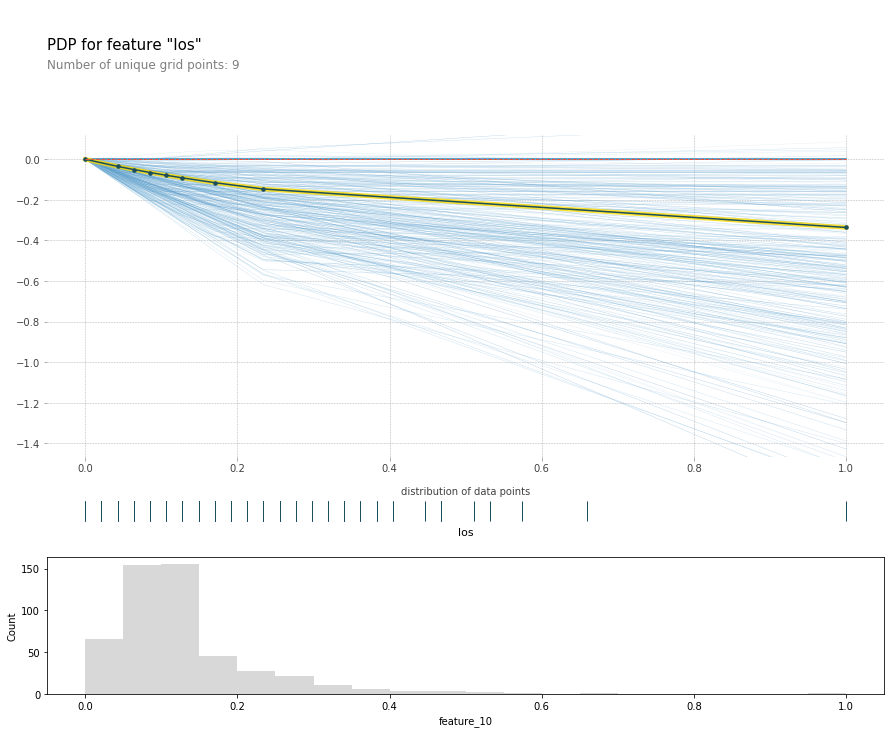

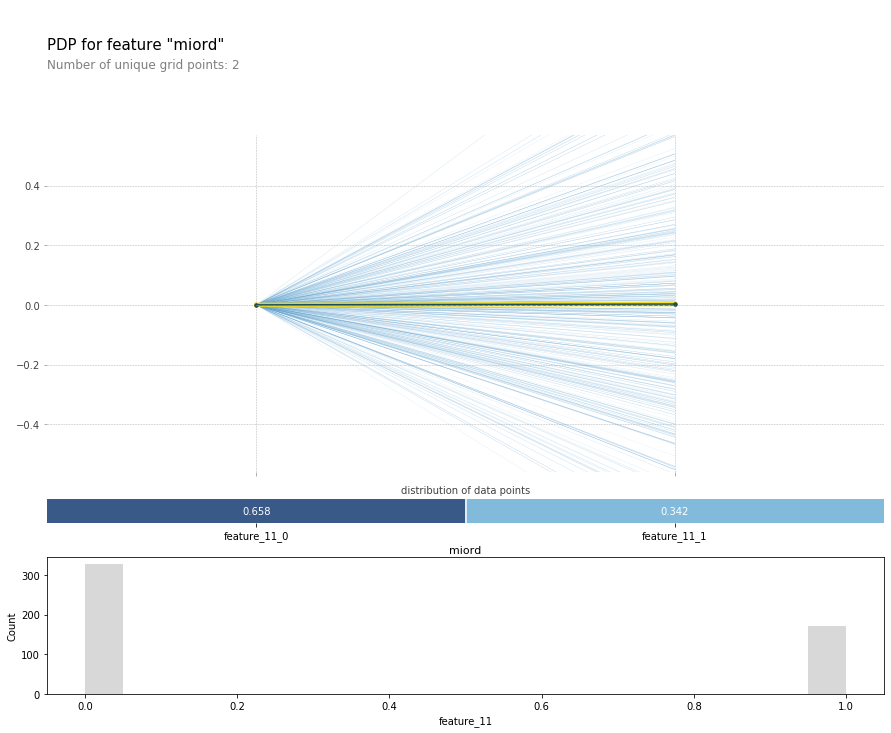

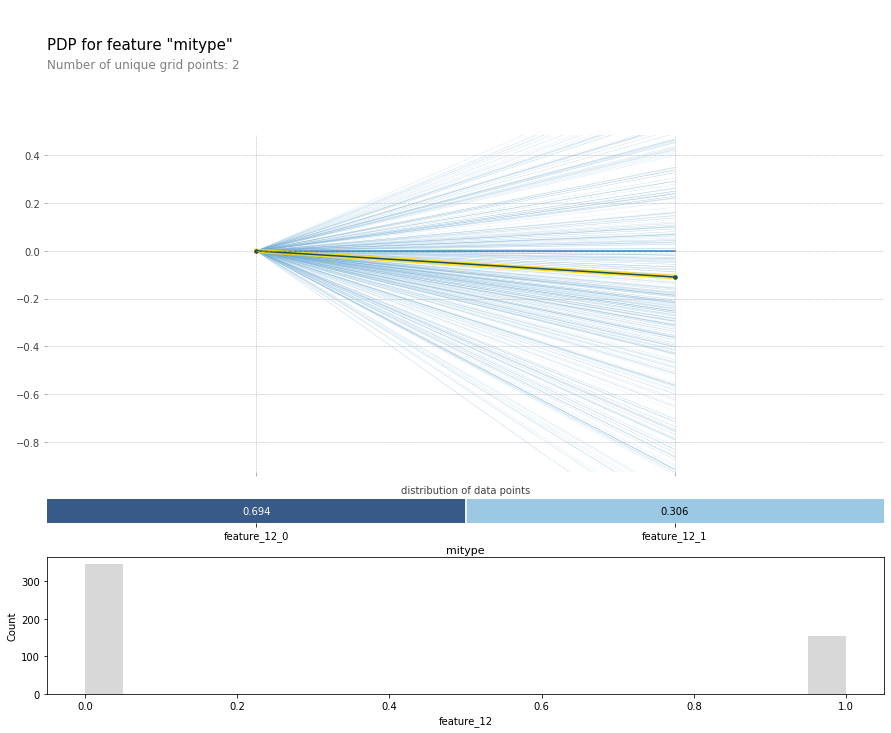

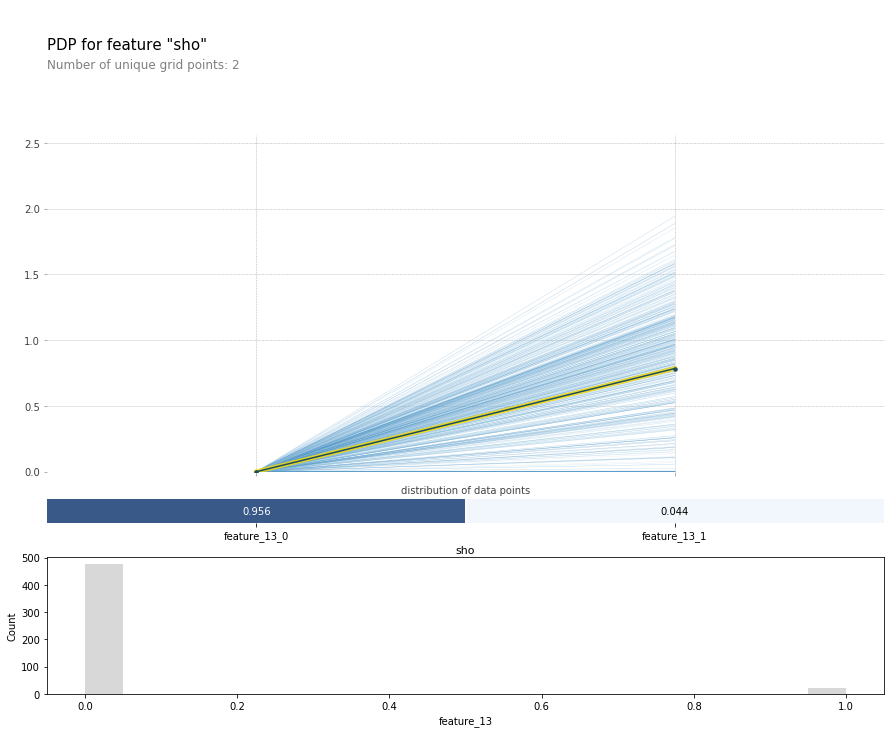

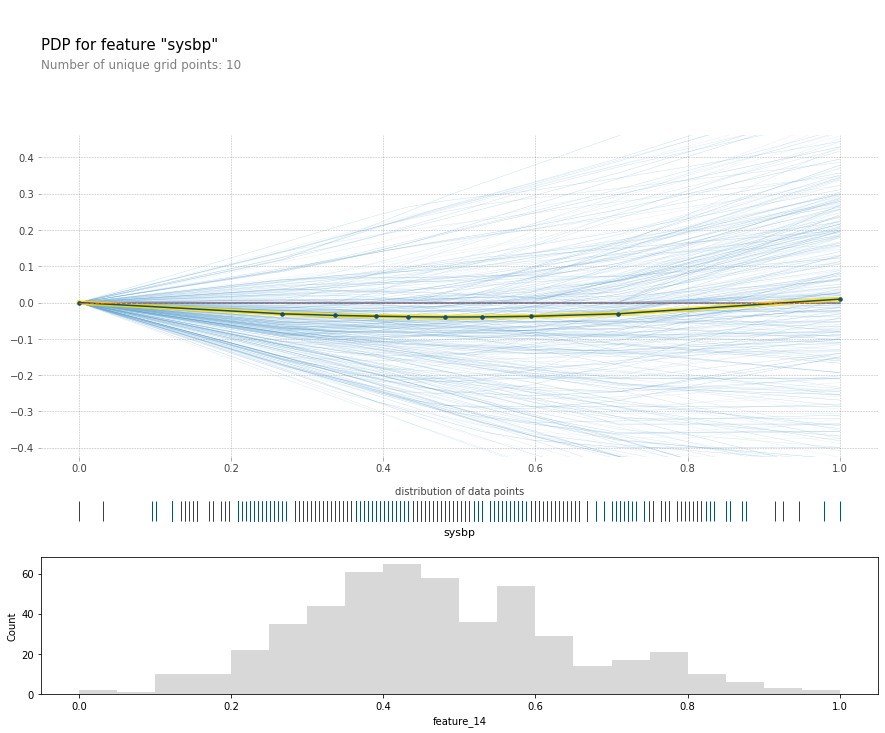

In [39]:
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot

# Generate the PDP plots with histograms below for all features
for i, feature in enumerate(feature_names, 1):
    pdp_feature = pdp_isolate(
        model=wrapped_model,
        dataset=surv_XDF,
        model_features=feature_names,
        feature=feature
    )
    fig, axes = pdp_plot(pdp_feature, cols[i-1], plot_lines=True, frac_to_plot=1, plot_pts_dist=True)

    # Add a histogram of the feature values below the PDP plot
    ax2 = fig.add_axes([fig.axes[-1].get_position().x0, fig.axes[-1].get_position().y0 - 0.25,
                        fig.axes[-1].get_position().width, 0.2])
    ax2.hist(surv_XDF[feature], bins=20, alpha=0.3, color='gray')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('Count')

    plt.show()


In [40]:
surv_XDF

feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0          1.0   0.716216        0.0   0.393008        0.0        1.0   
1          0.0   0.256757        0.0   0.345308        0.0        1.0   
2          0.0   0.540541        0.0   0.286142        0.0        0.0   
3          0.0   0.540541        0.0   0.427334        1.0        1.0   
4          0.0   0.540541        0.0   0.357530        0.0        1.0   
..         ...        ...        ...        ...        ...        ...   
495        1.0   0.621622        0.0   0.469251        0.0        1.0   
496        0.0   0.621622        0.0   0.353003        0.0        1.0   
497        1.0   0.364865        0.0   0.914979        0.0        1.0   
498        0.0   0.500000        0.0   0.451779        0.0        1.0   
499        0.0   0.918919        0.0   0.202567        0.0        1.0   

     feature_7  feature_8  feature_9  feature_10  feature_11  feature_12  \
0     0.375000        0.0   0.357616    0.106383         1.0         0.0   
1     0.281250        0.0   0.324503    0.106383         0.0         1.0   
2     0.427083        1.0   0.317881    0.106383         0.0         1.0   
3     0.364583        0.0   0.198675    0.212766         0.0         1.0   
4     0.411458        0.0   0.185430    0.127660         0.0         1.0   
..         ...        ...        ...         ...         ...         ...   
495   0.427083        1.0   0.218543    0.021277         0.0         1.0   
496   0.468750        1.0   0.350993    0.063830         0.0         0.0   
497   0.354167        1.0   0.582781    0.063830         0.0         0.0   
498   0.291667        0.0   0.158940    0.021277         0.0         1.0   
499   0.489583        0.0   0.423841    0.063830         0.0         1.0   

     feature_13  feature_14  
0           0.0    0.508021  
1           0.0    0.336898  
2           0.0    0.481283  
3           0.0    0.352941  
4           0.0    0.417112  
..          ...         ...  
495         0.0    0.294118  
496         0.0    0.807487  
497         0.0    0.336898  
498         0.0    0.294118  
499         0.0    0.550802  

[500 rows x 14 columns]

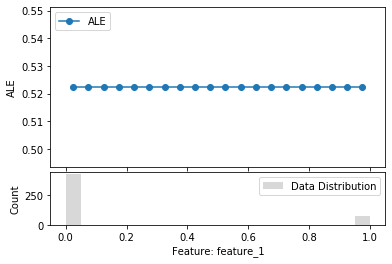

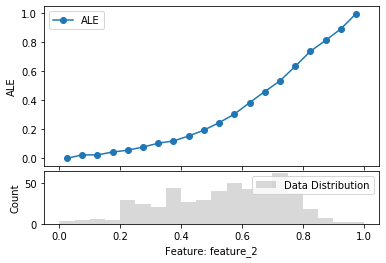

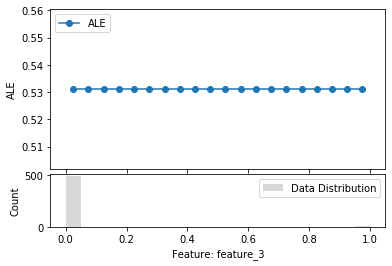

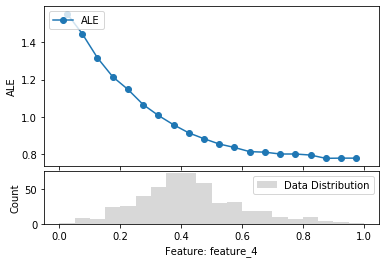

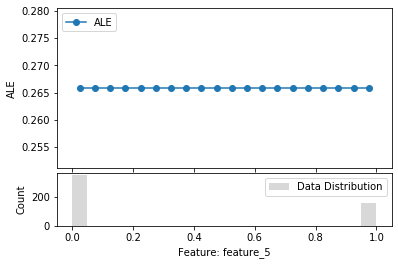

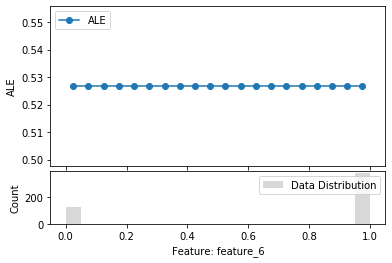

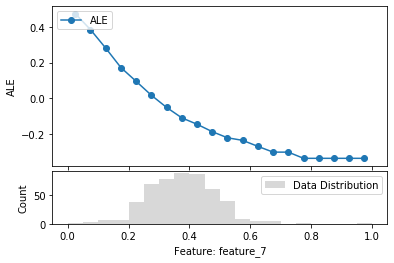

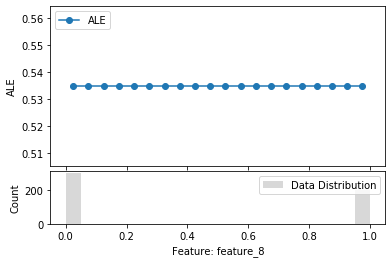

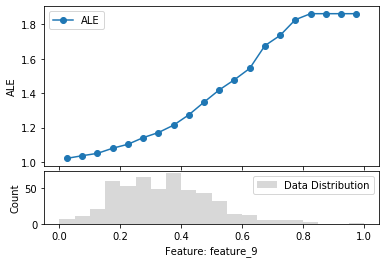

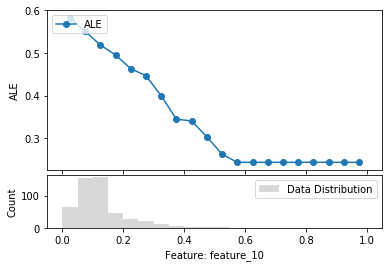

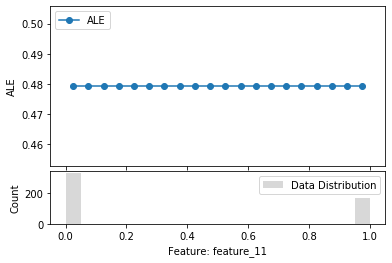

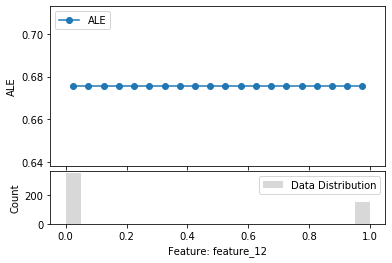

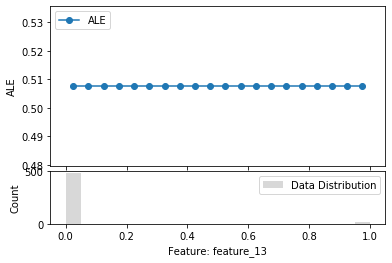

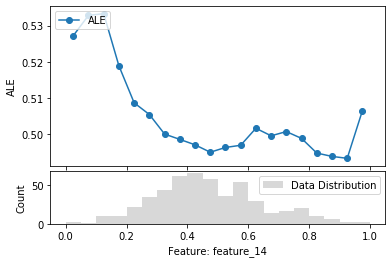

In [41]:
from PyALE import ale

import torch.nn as nn
from sklearn.base import BaseEstimator

# ... (all previous code up to WrappedModel definition remains the same)

import torch.nn as nn
class WrappedModel(nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, x):
        x = torch.tensor(x.to_numpy(), dtype=torch.float32).to(device)
        x = self.model(x)
        return x.detach().cpu().numpy()

    # Add the predict method
    def predict(self, x):
        return self.forward(x)

wrapped_model = WrappedModel(model)
def model_predict(X):
    return wrapped_model.predict(X)

X_df = surv_XDF
def compute_ale(predict_fn, X, feature, bins=20):
    X_sorted = X.sort_values(by=feature)
    bin_edges = np.linspace(X_sorted[feature].min(), X_sorted[feature].max(), bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ale_values = np.zeros(bins)

    for i in range(bins):
        subset = X_sorted[(X_sorted[feature] >= bin_edges[i]) & (X_sorted[feature] < bin_edges[i + 1])]
        if len(subset) == 0:
            continue
        ale_values[i] = predict_fn(subset).mean()
        if i > 0:
            modified_subset = subset.copy()
            modified_subset[feature] = bin_centers[i - 1]
            ale_values[i] -= predict_fn(modified_subset).mean()
    
    return bin_centers, np.cumsum(ale_values)


def plot_ale_with_bottom_histogram(predict_fn, X, feature, bins=20):
    bin_centers, ale_values = compute_ale(predict_fn, X, feature, bins)
    
    # Create the ALE plot and histogram in a 2-row grid
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    fig.subplots_adjust(hspace=0.05)

    # ALE plot
    ax1.plot(bin_centers, ale_values, marker='o', label='ALE')
    ax1.set_ylabel(f'ALE')
    ax1.legend(loc='upper left')

    # Histogram (data distribution)
    ax2.hist(X[feature], bins=bins, alpha=0.3, color='gray', label='Data Distribution')
    ax2.set_xlabel(f'Feature: {feature}')
    ax2.set_ylabel('Count')
    ax2.legend(loc='upper right')

    plt.show()

# Generate the ALE plots with histograms below for all features
for i, feature in enumerate(feature_names, 1):
    plot_ale_with_bottom_histogram(wrapped_model.predict, X_df, feature, bins=20)



# ICE

In [42]:
from pycebox.ice import ice, ice_plot
import torch.nn as nn
class WrappedModel(nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32).to(device)
        x = self.model(x)
        return x.detach().cpu().numpy()

    # Add the predict method
    def predict(self, x):
        return self.forward(x)

wrapped_model = WrappedModel(model)


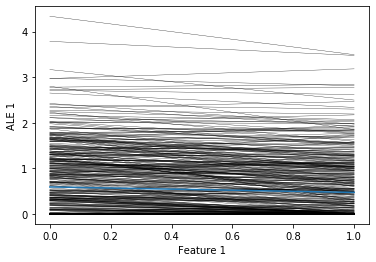

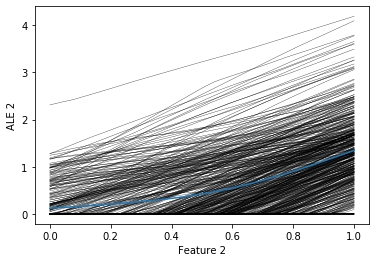

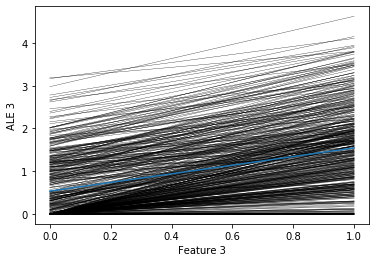

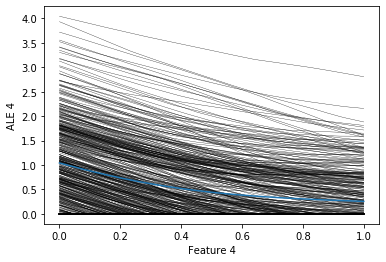

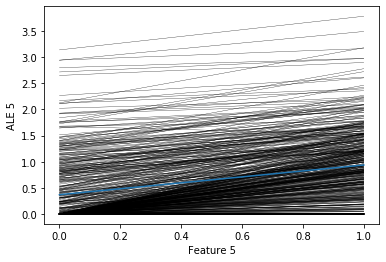

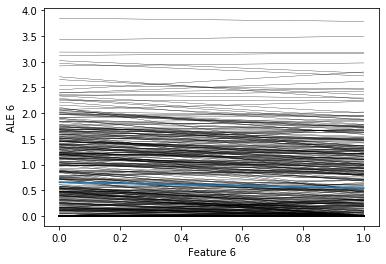

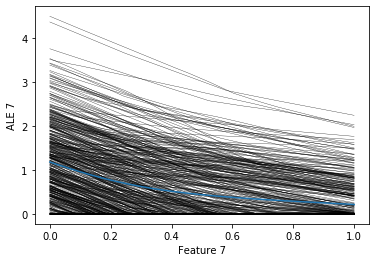

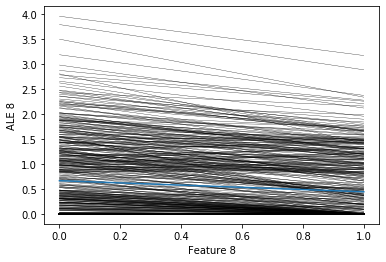

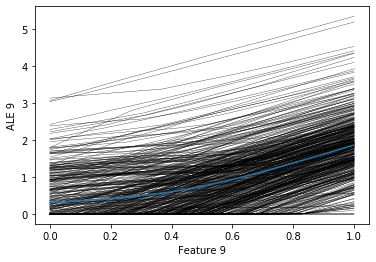

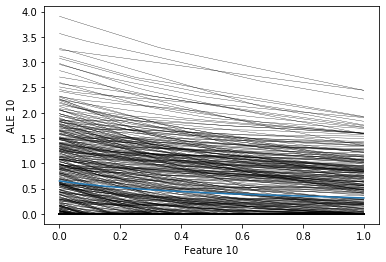

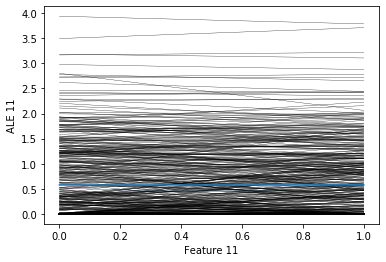

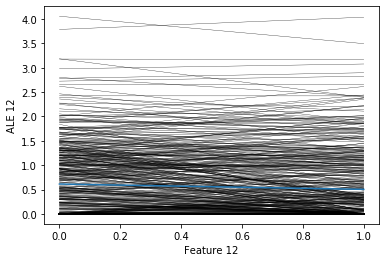

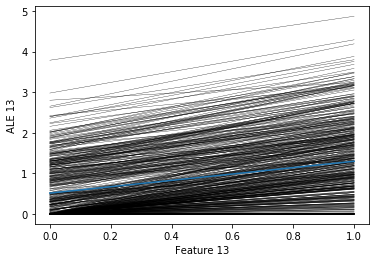

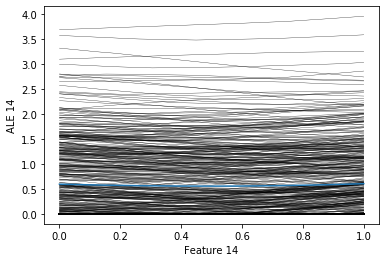

In [43]:
for i, feature in enumerate(feature_names, 1):
    centered_ice_df = ice(data=surv_XDF, column=feature, predict=wrapped_model.predict)
    ice_plot(centered_ice_df, c='k', linewidth=0.3, plot_pdp=True)
    plt.xlabel(f'Feature {i}')
    plt.ylabel(f'ALE {i}')
    plt.show()

In [ ]:
for i, feature in enumerate(feature_names, 1):
    centered_ice_df = ice(data=surv_XDF, column=feature, predict=wrapped_model.predict)
    fig, ax = plt.subplots()
    ax.axhline(y=centered_ice_df.iloc[0].values[0], color='k', linestyle='--', label='Center')
    ice_plot(centered_ice_df, ax=ax, c='k', linewidth=0.3)
    plt.xlabel(f'Feature {i}')
    plt.ylabel(f'ALE {i}')
    plt.legend()
    plt.show()


In [ ]:
def prototype_and_criticisms(model, X_train, y_train, X_test, y_test, k_prototypes=5, k_criticisms=5, device='cpu'):
    """
    Identifies prototype and criticism examples for a given PyTorch survival model.

    Parameters:
        model (nn.Module): A trained PyTorch model.
        X_train (numpy array or tensor): The training data (samples x features).
        y_train (numpy array or tensor): The training target (survival data).
        X_test (numpy array or tensor): The testing data (samples x features).
        y_test (numpy array or tensor): The testing target (survival data).
        k_prototypes (int): Number of prototype examples to identify.
        k_criticisms (int): Number of criticism examples to identify.
        device (str): Device to use for computation ('cpu' or 'cuda').

    Returns:
        A tuple of (prototypes, criticisms), where each is a tuple of the form (X, y).
    """
    # Set model to evaluation mode
    model.eval()

    # Convert inputs to tensors and move to device
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

    # Compute training and testing predictions
    train_pred = model(X_train).squeeze().detach().cpu().numpy()
    test_pred = model(X_test).squeeze().detach().cpu().numpy()

    # Compute residuals for training and testing data
    train_resid = y_train[:, 0].cpu().numpy() - train_pred
    test_resid = y_test[:, 0].cpu().numpy() - test_pred

    # Identify prototype examples
    prototypes = np.zeros((k_prototypes, X_train.shape[1]))
    for i in range(k_prototypes):
        # Find index of example with highest absolute residual
        idx = np.argmax(np.abs(train_resid))
        # Add example to prototypes
        prototypes[i, :] = X_train[idx, :].cpu().numpy()
        # Remove example from training data and residuals
        X_train = torch.cat([X_train[:idx, :], X_train[(idx+1):, :]], dim=0)
        y_train = torch.cat([y_train[:idx, :], y_train[(idx+1):, :]], dim=0)
        train_resid = np.concatenate([train_resid[:idx], train_resid[(idx+1):]], axis=0)

    # Identify criticism examples
    criticisms = np.zeros((k_criticisms, X_test.shape[1]))
    for i in range(k_criticisms):
        # Find index of example with highest absolute residual
        idx = np.argmax(np.abs(test_resid))
        # Add example to criticisms
        criticisms[i, :] = X_test[idx, :].cpu().numpy()
        # Remove example from testing data and residuals
        X_test = torch.cat([X_test[:idx, :], X_test[(idx+1):, :]], dim=0)
        y_test = torch.cat([y_test[:idx, :], y_test[(idx+1):, :]], dim=0)
        test_resid = np.concatenate([test_resid[:idx], test_resid[(idx+1):]], axis=0)

    return (prototypes, criticisms)


In [ ]:
prototypes, criticisms = prototype_and_criticisms(model = model.cpu(), 
X_train = surv_XDF.to_numpy()[:100], 
y_train = (life[['Status', 'Survival_in_days']].to_numpy()[:100]*1).astype('float64'), 
X_test = surv_XDF.to_numpy()[100:],
y_test = (life[['Status', 'Survival_in_days']].to_numpy()[100:]*1).astype('float64'), 
k_prototypes=5, 
k_criticisms=5, 
device='cpu')

In [ ]:
k_prototypes = 5
k_criticisms = 5
fig, axs = plt.subplots(nrows=2, ncols=k_prototypes, figsize=(20, 6))
for i in range(k_prototypes):
    axs[0, i].plot(prototypes[i])
    axs[0, i].set_title(f"Prototype {i+1}")
for i in range(k_criticisms):
    axs[1, i].plot(criticisms[i])
    axs[1, i].set_title(f"Criticism {i+1}")
plt.tight_layout()
plt.show()